In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/heartbeat/ptbdb_abnormal.csv
/kaggle/input/heartbeat/ptbdb_normal.csv
/kaggle/input/heartbeat/mitbih_test.csv
/kaggle/input/heartbeat/mitbih_train.csv


#  **Step 2: Load and Inspect**

In [2]:
import pandas as pd

# Load the data with header=None
train_df = pd.read_csv('/kaggle/input/heartbeat/mitbih_train.csv', header=None)

# Check the first few rows again
print(train_df.head())

        0         1         2         3         4         5         6    \
0  0.977941  0.926471  0.681373  0.245098  0.154412  0.191176  0.151961   
1  0.960114  0.863248  0.461538  0.196581  0.094017  0.125356  0.099715   
2  1.000000  0.659459  0.186486  0.070270  0.070270  0.059459  0.056757   
3  0.925414  0.665746  0.541436  0.276243  0.196133  0.077348  0.071823   
4  0.967136  1.000000  0.830986  0.586854  0.356808  0.248826  0.145540   

        7         8         9    ...  178  179  180  181  182  183  184  185  \
0  0.085784  0.058824  0.049020  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  0.088319  0.074074  0.082621  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2  0.043243  0.054054  0.045946  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3  0.060773  0.066298  0.058011  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4  0.089202  0.117371  0.150235  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

   186  187  
0  0.0  0.0  
1  0.0  0.0  
2  0.0  0.0  
3  0.0  0.0 

# **Step 2.1: See the number of columns and rows**

In [3]:
print(train_df.shape)

(87554, 188)


# **Step 3: Separate Signals from Labels**

Shape of X: (87554, 187)
Shape of y: (87554,)


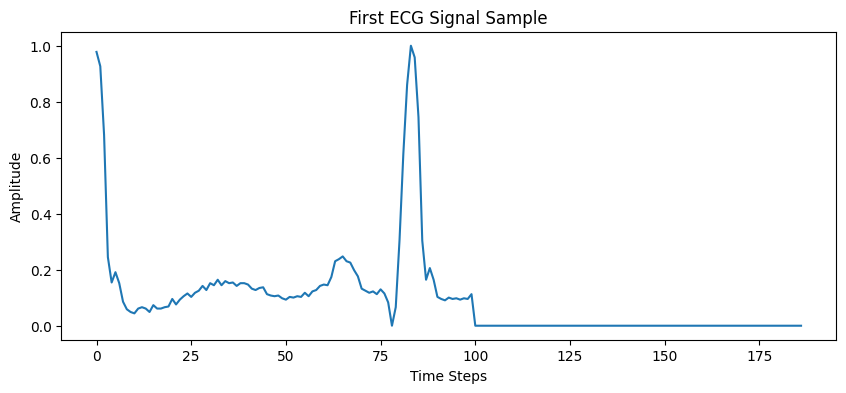

In [4]:
import matplotlib.pyplot as plt

# X contains all rows, and all columns EXCEPT the last one (0 to 186)
X = train_df.iloc[:, :-1]

# y contains all rows, and ONLY the last column (index 187)
y = train_df.iloc[:, -1]

print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

# Plot the first ECG signal to verify
plt.figure(figsize=(10, 4))
plt.plot(X.iloc[0])
plt.title("First ECG Signal Sample")
plt.xlabel("Time Steps")
plt.ylabel("Amplitude")
plt.show()

# **Step 4: Reshaping for LSTM**
Right now, your data is 2D: (87554, 187). Now, to convert into 3D shape, there is 1 feature (amplitude) per time step. LSTMs need to know:

* How many samples? (87,554)
* How many time steps in each sample? (187)
* How many features at each time step? (1)

In [5]:
import numpy as np

# Convert to numpy and reshape to (samples, time_steps, features)
X_reshaped = X.values.reshape(X.shape[0], X.shape[1], 1)

print("New shape:", X_reshaped.shape)

New shape: (87554, 187, 1)


# **Step 5: Build the LSTM Autoencoder**
We will use a Sequential model.

* **LSTM Layer 1:** Takes the input. return_sequences=True ensures it passes the full sequence to the next layer.
* **LSTM Layer 2:** Also return_sequences=True to keep the temporal structure.
* **TimeDistributed(Dense(1)):** This applies a dense layer to every time step individually to get our single amplitude value back.

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, TimeDistributed, Input

# Define the model architecture
model = Sequential([
    Input(shape=(187, 1)),
    
    # Encoder / Decoder flow
    LSTM(64, return_sequences=True),
    LSTM(32, return_sequences=True), # Compress representation
    LSTM(64, return_sequences=True), # Expand back
    
    # Output layer: Project back to 1 feature per time step
    TimeDistributed(Dense(1))
])

# Compile the model
# MSE (Mean Squared Error) is standard for signal reconstruction
model.compile(optimizer='adam', loss='mse')

model.summary()

2025-12-29 11:23:18.634364: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1767007398.786785      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1767007398.827511      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1767007399.199499      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767007399.199523      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767007399.199526      55 computation_placer.cc:177] computation placer alr

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 187, 64)        │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 187, 32)        │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 187, 64)        │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 187, 1)         │            65 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 54,209 (211.75 KB)

 Trainable params: 54,209 (211.75 KB)

 Non-trainable params: 0 (0.00 B)

# **Step 6: Train the Model**
Now we fit the model. For an autoencoder-style task (reconstruction), the target y is actually the input X itself (or the X_reshaped version), because we want the model to learn to output exactly what it saw.

In [7]:
# Train the model
# Note: X_reshaped is both the input AND the target
history = model.fit(
    X_reshaped, X_reshaped,
    epochs=20,           # Adjust based on time/patience
    batch_size=32,
    validation_split=0.1,
    verbose=1
)

Epoch 1/20


I0000 00:00:1767007421.083969     125 cuda_dnn.cc:529] Loaded cuDNN version 91002


2463/2463 ━━━━━━━━━━━━━━━━━━━━ 79s 29ms/step - loss: 0.0055 - val_loss: 1.7391e-05
Epoch 2/20
2463/2463 ━━━━━━━━━━━━━━━━━━━━ 68s 27ms/step - loss: 1.3667e-05 - val_loss: 5.0204e-06
Epoch 3/20
2463/2463 ━━━━━━━━━━━━━━━━━━━━ 68s 27ms/step - loss: 6.3702e-06 - val_loss: 3.9128e-06
Epoch 4/20
2463/2463 ━━━━━━━━━━━━━━━━━━━━ 68s 27ms/step - loss: 5.4918e-06 - val_loss: 1.0789e-06
Epoch 5/20
2463/2463 ━━━━━━━━━━━━━━━━━━━━ 67s 27ms/step - loss: 1.0311e-06 - val_loss: 9.3098e-07
Epoch 6/20
2463/2463 ━━━━━━━━━━━━━━━━━━━━ 68s 27ms/step - loss: 2.3231e-06 - val_loss: 2.5293e-07
Epoch 7/20
2463/2463 ━━━━━━━━━━━━━━━━━━━━ 67s 27ms/step - loss: 1.0175e-06 - val_loss: 1.8604e-06
Epoch 8/20
2463/2463 ━━━━━━━━━━━━━━━━━━━━ 67s 27ms/step - loss: 1.6131e-06 - val_loss: 1.3361e-07
Epoch 9/20
2463/2463 ━━━━━━━━━━━━━━━━━━━━ 68s 27ms/step - loss: 3.5404e-07 - val_loss: 1.2125e-07
Epoch 10/20
2463/2463 ━━━━━━━━━━━━━━━━━━━━ 68s 27ms/step - loss: 8.6301e-07 - val_loss: 7.7760e-08
Epoch 11/20
2463/2463 ━━━━━━━━━━━━

# **Task 7a: Load the Test Data**

In [8]:
import pandas as pd
import numpy as np

# 1. Load the test data
test_df = pd.read_csv('/kaggle/input/heartbeat/mitbih_test.csv', header=None)

# 2. Separate signals (X) from labels (y)
X_test = test_df.iloc[:, :-1].values

# 3. Reshape for the LSTM: (samples, 187, 1)
X_test_reshaped = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print("Test Data Shape:", X_test_reshaped.shape)

Test Data Shape: (21892, 187, 1)


# **Task 7b: Create "Broken" Samples**

In [9]:
import random

# 1. Pick 5 random indices
random_indices = random.sample(range(X_test_reshaped.shape[0]), 5)

# 2. Get the original clean signals
original_samples = X_test_reshaped[random_indices]

# 3. Create a copy to "break"
masked_samples = original_samples.copy()

# 4. Remove 20% of the signal (approx steps 100 to 137)
# We set this region to 0 to simulate data loss
masked_samples[:, 100:137, :] = 0

print("Created 5 masked samples with missing data.")

Created 5 masked samples with missing data.


# **Task 7c: Attempt Recovery**

In [10]:
# Predict the recovered signals using the broken inputs
recovered_samples = model.predict(masked_samples)

print("Recovery complete. Prediction shape:", recovered_samples.shape)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Recovery complete. Prediction shape: (5, 187, 1)


# **Task 7d: Visualizing the Results**
Finally, we calculate the error (RMS) and plot all three versions:

* Green: The real, original signal.
* Red (Dashed): The broken signal we gave the model.
* Blue: The model's attempt to fix it.

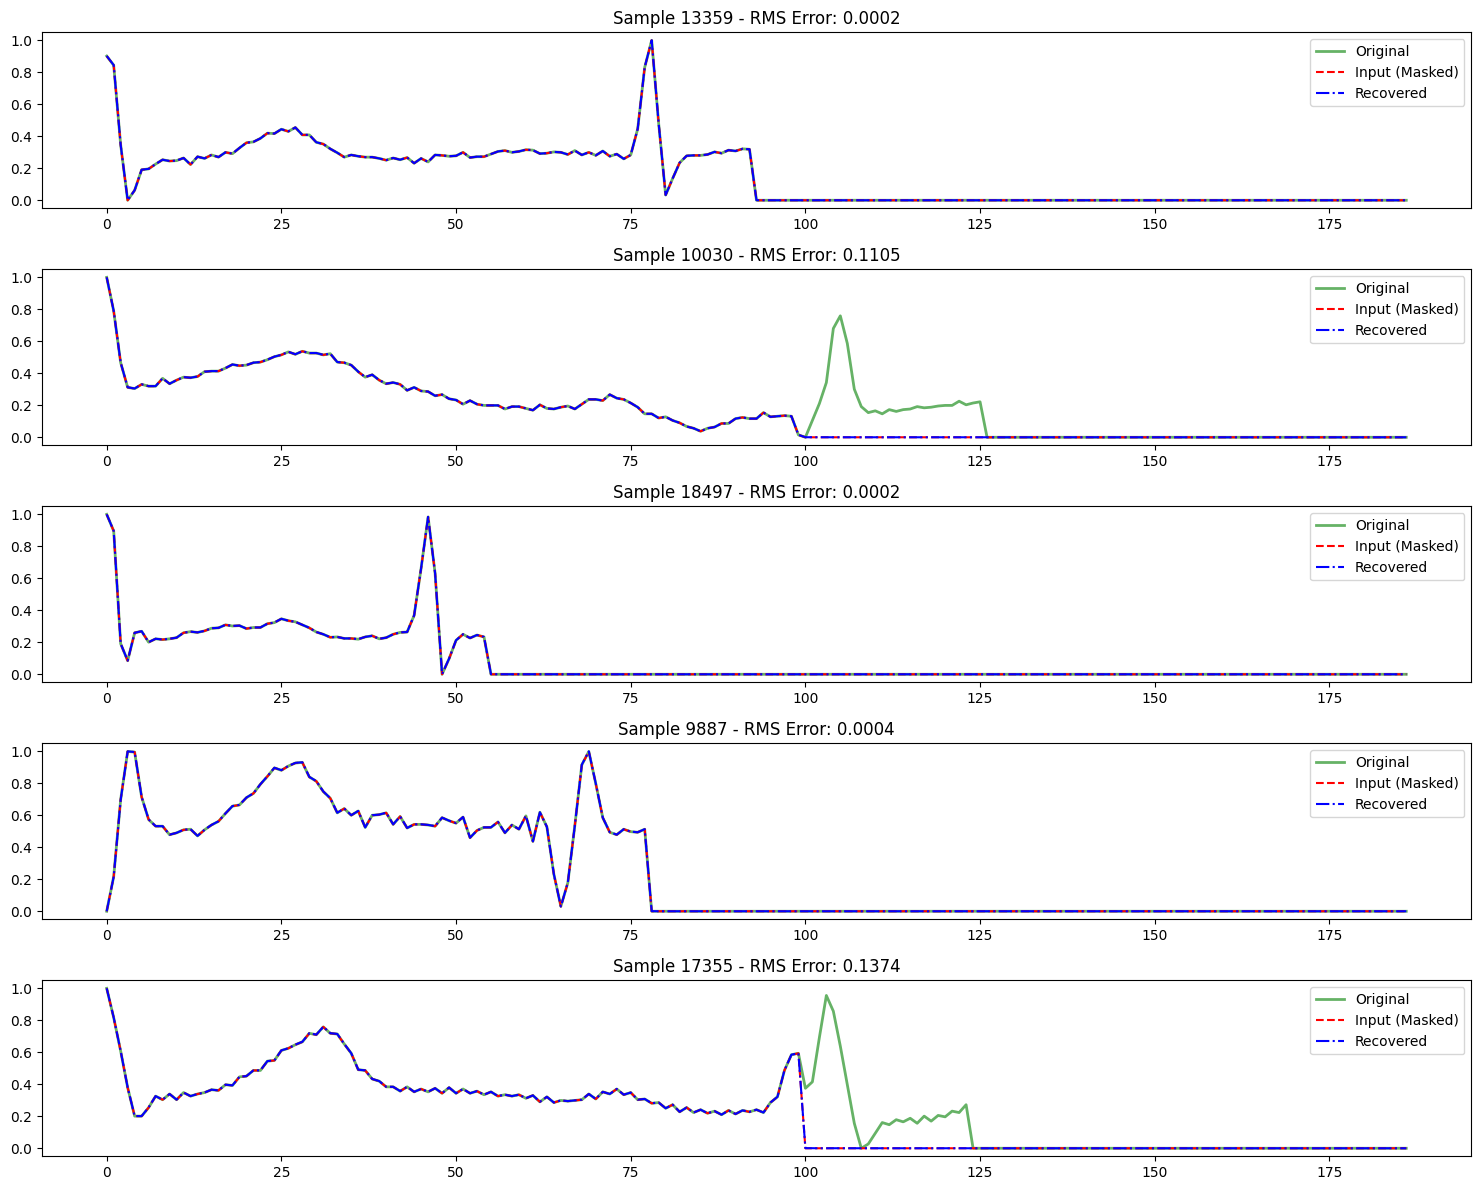

In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

plt.figure(figsize=(15, 12))

for i in range(5):
    # Calculate how close the recovery is to the original (RMS Error)
    rmse = np.sqrt(mean_squared_error(original_samples[i].flatten(), recovered_samples[i].flatten()))
    
    ax = plt.subplot(5, 1, i + 1)
    
    # Plot Original (Green)
    plt.plot(original_samples[i].flatten(), label='Original', color='green', linewidth=2, alpha=0.6)
    
    # Plot Masked Input (Red dashed)
    plt.plot(masked_samples[i].flatten(), label='Input (Masked)', color='red', linestyle='--')
    
    # Plot Recovered (Blue)
    plt.plot(recovered_samples[i].flatten(), label='Recovered', color='blue', linestyle='-.')
    
    plt.title(f"Sample {random_indices[i]} - RMS Error: {rmse:.4f}")
    plt.legend()

plt.tight_layout()
plt.show()